# Multi Label Classification With MIML dataset

After all that had occured with the Protiens dataset, I could not figure out what was wrong. After doing some research I decided to follow this https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24 but with my model instead of the one that the person builds

In [1]:
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import pandas as pd 
import numpy as np 


from PIL import Image
#from tensorflow import keras

import tensorflow as tf
from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,LSTM,Dense,Dropout
from tensorflow.keras.layers import BatchNormalization,Activation, Flatten
from tensorflow.keras.layers import Concatenate as con
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras import backend as K

import os

In [2]:
print(os.getcwd())

/home/paperspace/fastai/focus


In [3]:
df = pd.read_csv("./miml_dataset/miml_labels_1.csv")

In [4]:
df.head()

,Filenames,desert,mountains,sea,sunset,trees
0,1.jpg,1,0,0,0,0
1,2.jpg,1,0,0,0,0
2,3.jpg,1,0,0,0,0
3,4.jpg,1,1,0,0,0
4,5.jpg,1,0,0,0,0


In [5]:
columns = ["desert","mountains", "sea","sunset","trees"]

datagen = IDG(rescale = 1./255.)
test_datagen = IDG(rescale = 1./255.)

train_generator = datagen.flow_from_dataframe(
dataframe = df[:1800],
directory = "./miml_dataset/images",
x_col = "Filenames",
y_col = columns,
batch_size = 32,
seed = 42,
shuffle = True,
class_mode = "other",
target_size = (100,100))

valid_generator = datagen.flow_from_dataframe(
dataframe = df[1800:1900],
directory = "./miml_dataset/images",
x_col = "Filenames",
y_col = columns,
batch_size = 32,
seed = 42,
shuffle = True,
class_mode = "other",
target_size = (100,100))

test_generator = datagen.flow_from_dataframe(
dataframe = df[1900:],
directory = "./miml_dataset/images",
x_col = "Filenames",
y_col = columns,
batch_size = 1,
seed = 42,
shuffle = True,
class_mode = "other",
target_size = (100,100))


Found 1800 images.
Found 100 images.
Found 100 images.


In [6]:
n_classes = 5

In [7]:
input_shape=(100,100,3)

inputs = Input(name='the_input', shape=input_shape, dtype='float32')  

       # Convolution layer (VGG)
inner = Conv2D(64, (3, 3), padding='same', name='conv1', 
               kernel_initializer='he_normal')(inputs)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)

inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner) 

inner = Conv2D(128, (3, 3), padding='same', name='conv3', 
               kernel_initializer='he_normal')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(128, (3, 3), padding='same', name='conv4', 
               kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  

inner = Conv2D(256, (3, 3), padding='same', name='conv5', 
               kernel_initializer='he_normal')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(256, (3, 3), padding='same', name='conv6', 
               kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(256, (3, 3), padding='same', name='conv7', 
               kernel_initializer='he_normal')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner) 

inner = Conv2D(512, (3, 3), padding='same', name='conv8',
               kernel_initializer='he_normal')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (3, 3), padding='same', 
               kernel_initializer='he_normal' ,name='conv9')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (2, 2), padding='same', 
               kernel_initializer='he_normal', name='con10')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)  

inner = Conv2D(512, (2, 2), padding='same', 
               kernel_initializer='he_normal', name='con11')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (2, 2), padding='same', 
               kernel_initializer='he_normal', name='con12')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)

inner = Dense(64, activation='relu', 
              kernel_initializer='he_normal', name='dense_small')(inner) 


inner = Flatten()(inner)
inner = Dense(4096, kernel_initializer='he_normal', name = 'fc1')(inner)
inner = Activation('relu')(inner)
inner = Dropout(0.3)(inner)
inner = Dense(4096, kernel_initializer = 'he_normal',name = 'fc2')(inner)
inner = Activation('relu')(inner)
inner=Dropout(0.3)(inner)
finalPred = Dense(5,kernel_initializer = 'he_normal', 
                  name = 'dense_final', activation='sigmoid')(inner)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [9]:
cnn = Model(inputs=inputs, outputs= finalPred)

In [19]:
cnn.compile(optimizer=Adam(decay=1e-6), 
            loss= "binary_crossentropy",
              metrics=[f1,'accuracy'])

In [20]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 100, 100, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 64)      0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 50, 50, 128)       73856     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 50, 50, 128)       512       
__________

In [21]:
input_shape=(100,100,3)

inputz = Input(name='the_input', shape=input_shape, dtype='float32')  

inner = Conv2D(64, (3, 3), padding='same', name='conv1', 
               kernel_initializer='he_normal')(inputz)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  

inner = Conv2D(128, (3, 3), padding='same', name='conv2', 
               kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner) 

inner = Conv2D(256, (3, 3), padding='same', name='conv3', 
               kernel_initializer='he_normal')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(256, (3, 3), padding='same', name='conv4', 
               kernel_initializer='he_normal')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  

inner = Conv2D(512, (3, 3), padding='same', name='conv5', 
               kernel_initializer='he_normal')(inner) 
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512, (3, 3), padding='same', name='conv6')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)  
inner = Conv2D(512, (2, 2), padding='same', 
               kernel_initializer='he_normal', name='con7')(inner)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
    # CNN to RNN
inner = tf.keras.layers.Reshape(target_shape=((25, 512*6)), name='reshape')(inner)  
inner = Dense(64, activation='relu', kernel_initializer='he_normal',
              name='dense_smaller')(inner) 


    # RNN layer
lstm_1 = LSTM(256, return_sequences=False,
              kernel_initializer='he_normal', name='lstm1')(inner)  
lstm_1b = LSTM(256, return_sequences=False, go_backwards=True, 
               kernel_initializer='he_normal', name='lstm1_b')(inner)
reversed_lstm_1b = tf.keras.layers.Lambda(lambda inputTensor: 
                                          K.reverse(inputTensor, axes=1)) (lstm_1b)

lstm1_merged = tf.keras.layers.add([lstm_1, reversed_lstm_1b])  
lstm1_merged = BatchNormalization()(lstm_1)


finalPred1 = Dense(n_classes, kernel_initializer = 'he_normal',name='dense', 
                   activation = 'sigmoid')(lstm1_merged)

In [22]:
cnn_lstm = Model(inputs=inputz, outputs= finalPred1 )

In [23]:
cnn_lstm.compile(optimizer=Adam(lr=0.0001,  decay=1e-6), loss= "binary_crossentropy",
              metrics=[ 'accuracy' ,f1])

In [24]:
cnn_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 100, 100, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization_v1_19 (B (None, 100, 100, 64)      256       
_________________________________________________________________
activation_20 (Activation)   (None, 100, 100, 64)      0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 50, 50, 128)       73856     
_________________________________________________________________
batch_normalization_v1_20 (B (None, 50, 50, 128)       512       
__________

In [25]:
cnn.reset_states()

In [26]:
def generator_wrapper(generator):
    for batch_x,batch_y in generator:
        yield (batch_x,[batch_y[:,i] for i in range(5)])


In [27]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=100//test_generator.batch_size


filepath = "CNN_MIML-{epoch:02d}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_f1', verbose=1, 
                             save_best_only=True, mode='max')

callback =  ReduceLROnPlateau(monitor='val_f1', factor=0.5, patience=3,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)

history = cnn.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15,
                    callbacks = [callback, checkpoint]
)

Epoch 1/15
4/4 [==============================] - 4s 1s/step - loss: 0.4050 - f1: 0.1592 - acc: 0.8660

Epoch 00001: val_f1 improved from -inf to 0.15924, saving model to VGG16-Take2-miml-klean-01.hdf5
57/57 [==============================] - 349s 6s/step - loss: 0.8118 - f1: 0.2604 - acc: 0.7357 - val_loss: 0.4050 - val_f1: 0.1592 - val_acc: 0.8660
Epoch 2/15
4/4 [==============================] - 4s 922ms/step - loss: 0.7642 - f1: 0.0704 - acc: 0.6400

Epoch 00002: val_f1 did not improve from 0.15924
57/57 [==============================] - 335s 6s/step - loss: 0.4776 - f1: 0.3806 - acc: 0.7833 - val_loss: 0.7642 - val_f1: 0.0704 - val_acc: 0.6400
Epoch 3/15
4/4 [==============================] - 3s 802ms/step - loss: 0.7224 - f1: 0.0847 - acc: 0.6260

Epoch 00003: val_f1 did not improve from 0.15924
57/57 [==============================] - 304s 5s/step - loss: 0.4257 - f1: 0.4554 - acc: 0.8106 - val_loss: 0.7224 - val_f1: 0.0847 - val_acc: 0.6260
Epoch 4/15
4/4 [====================

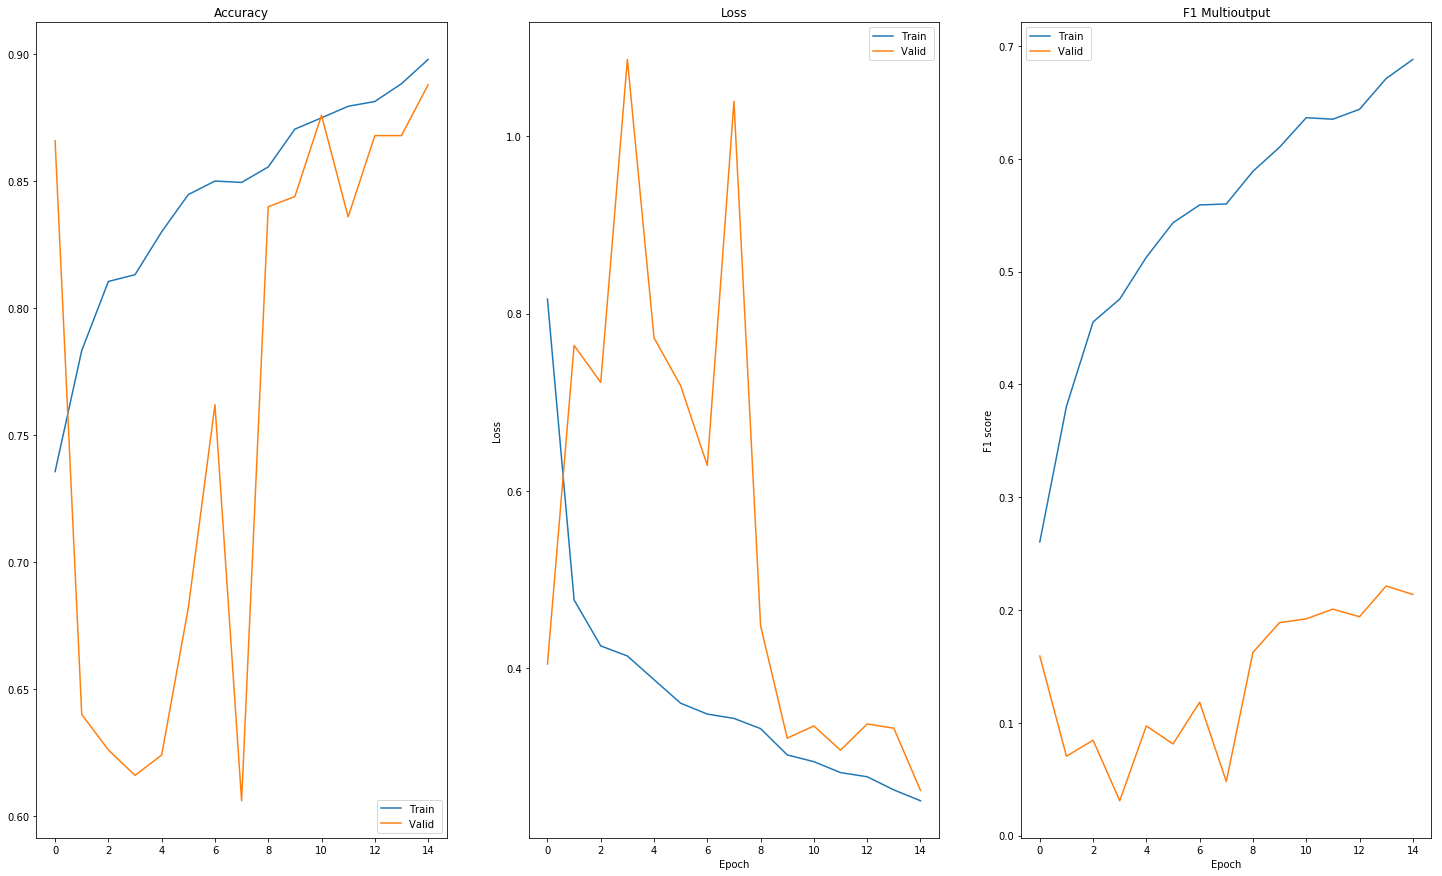

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(25,15))
ax[0].set_title('Accuracy')
ax[0].plot(history.history['acc'], label= 'Train ')
ax[0].plot(history.history['val_acc'], label = 'Valid ')
ax[0].set_title

ax[1].set_title('Loss')
ax[1].plot(history.history['loss'], label= 'Train ')
ax[1].plot(history.history['val_loss'], label = 'Valid ')
ax[1].set(xlabel="Epoch", ylabel="Loss")

ax[2].set_title('F1 ')
ax[2].set(xlabel="Epoch", ylabel="F1 score")
ax[2].plot(history.history['f1'], label= 'Train ')
ax[2].plot(history.history['val_f1'], label = 'Valid ')
ax[0].legend(loc="lower right")
ax[1].legend()
ax[2].legend()

plt.savefig('VGG16_MIML_SINGLE.png')



In [29]:
cnn_lstm.reset_states

<bound method Network.reset_states of <tensorflow.python.keras.engine.training.Model object at 0x7fc858a26780>>

In [30]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=100//test_generator.batch_size
filepath = "CNNLSTM-miml-{epoch:02d}.hdf5"


checkpoint1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, mode='max')
hist = cnn_lstm.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15,
                    callbacks = [callback,checkpoint1]
)

Epoch 1/15
4/4 [==============================] - 2s 581ms/step - loss: 0.7472 - acc: 0.3500 - f1: 0.1465

Epoch 00001: loss improved from -inf to 0.62902, saving model to CNNLSTM-mimlNICE-01.hdf5
57/57 [==============================] - 184s 3s/step - loss: 0.6326 - acc: 0.6774 - f1: 0.4456 - val_loss: 0.7472 - val_acc: 0.3500 - val_f1: 0.1465
Epoch 2/15
4/4 [==============================] - 2s 526ms/step - loss: 0.8066 - acc: 0.4000 - f1: 0.1458

Epoch 00002: loss did not improve from 0.62902
57/57 [==============================] - 182s 3s/step - loss: 0.4934 - acc: 0.7772 - f1: 0.5186 - val_loss: 0.8066 - val_acc: 0.4000 - val_f1: 0.1458
Epoch 3/15
4/4 [==============================] - 2s 530ms/step - loss: 0.7933 - acc: 0.4840 - f1: 0.1219

Epoch 00003: loss did not improve from 0.62902
57/57 [==============================] - 181s 3s/step - loss: 0.4106 - acc: 0.8330 - f1: 0.5778 - val_loss: 0.7933 - val_acc: 0.4840 - val_f1: 0.1219
Epoch 4/15
4/4 [=============================

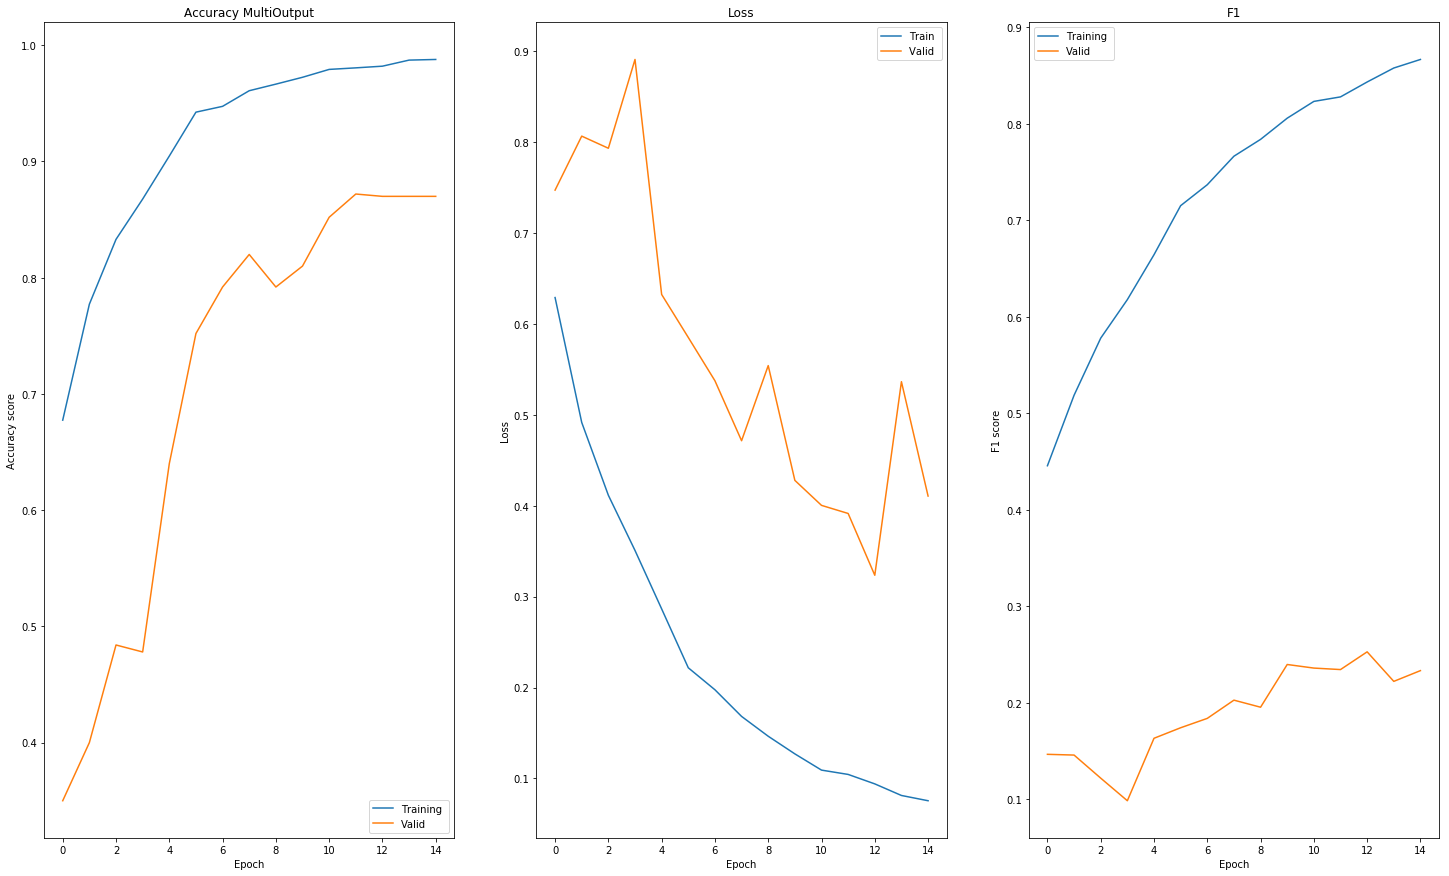

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(25,15))
ax[0].set_title('Accuracy MultiOutput')
ax[0].plot(hist.history['acc'], label = "Training ")
ax[0].plot(hist.history['val_acc'], label = "Valid")

ax[0].set(xlabel="Epoch", ylabel="Accuracy score")

ax[1].set_title('Loss')
ax[1].plot(hist.history['loss'], label= 'Train ')
ax[1].plot(hist.history['val_loss'], label = 'Valid ')
ax[1].set(xlabel="Epoch", ylabel="Loss")

ax[2].set_title('F1')
ax[2].set(xlabel="Epoch", ylabel="F1 score")
ax[2].plot(hist.history['f1'], label = "Training ")
ax[2].plot(hist.history['val_f1'], label = "Valid")
ax[0].legend(loc="lower right")
ax[1].legend()
ax[2].legend()
plt.savefig('CNNLSTM_MIML.png')

In [32]:
test_generator.reset()
cnn_preds = cnn.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose=1)
cnnLSTM_preds = cnn_lstm.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose=1)

100/100 [==============================] - 4s 44ms/step


In [42]:
cnn_preds

array([[3.00745536e-02, 8.63903105e-01, 2.06231371e-01, 5.72457619e-04,
        7.95569047e-02],
       [3.79055738e-01, 1.68050341e-02, 3.13158613e-03, 8.71215772e-04,
        7.87790537e-01],
       [6.35173097e-02, 5.37229607e-05, 3.59876227e-04, 3.24249704e-04,
        9.71022189e-01],
       [5.72719812e-01, 8.97893496e-03, 3.00672501e-01, 1.06648639e-01,
        3.97591263e-01],
       [3.09450775e-01, 7.52987014e-03, 4.06733006e-01, 3.33122388e-02,
        4.29929882e-01],
       [8.36179883e-04, 5.50197728e-04, 1.49488056e-04, 6.37859281e-04,
        9.98035729e-01],
       [3.97797616e-04, 1.19407047e-02, 3.73091325e-02, 2.48477067e-04,
        9.34925199e-01],
       [2.01182105e-04, 4.98045469e-03, 7.37481460e-05, 2.16402186e-05,
        9.98171329e-01],
       [1.29302742e-03, 9.88525867e-01, 2.33862083e-02, 4.68479993e-05,
        2.36343399e-01],
       [6.43532840e-05, 9.96102095e-01, 2.67067691e-03, 9.14844748e-07,
        6.71940744e-01],
       [2.55006924e-02, 6.0454

In [43]:
cnnLSTM_preds

array([[0.03164137, 0.02137147, 0.03355487, 0.51499707, 0.9999933 ],
       [0.14243968, 0.99961543, 0.21015632, 0.00516718, 0.43549192],
       [0.08480065, 0.01414621, 0.07450409, 0.04413239, 1.        ],
       [0.11218508, 0.00941451, 0.17457262, 0.04312698, 0.9997067 ],
       [0.02904848, 0.06512611, 0.9999902 , 0.21276724, 0.02443776],
       [0.08301598, 0.02656008, 0.21802738, 0.01204995, 0.9999913 ],
       [0.9996779 , 0.13966666, 0.02324299, 0.01643477, 0.7047761 ],
       [0.0703655 , 0.43765214, 0.04825007, 0.02272864, 0.9994974 ],
       [0.13387898, 0.9102489 , 0.06362139, 0.01082964, 0.54742527],
       [0.09318472, 0.8467955 , 0.05065657, 0.04044246, 0.9999999 ],
       [0.05109274, 0.42687458, 0.10145939, 0.0211347 , 1.        ],
       [0.99979204, 0.01822676, 0.01658749, 0.05954812, 0.9453491 ],
       [0.6105993 , 0.33520156, 0.65486187, 0.00617401, 0.98904127],
       [0.03169969, 0.10193895, 0.05733286, 0.02135115, 0.9999571 ],
       [0.2252133 , 0.97683495, 0.

In [41]:
predictions=[]
for i in range(len(cnn_preds)):
    l = []
    for j in range(len(cnn_preds[i])):
        if cnnLSTM_preds[i][j] > 0.5:
            l.append(1)
        else:
            l.append(0)
    predictions.append(l)
columns=["desert", "mountains", "sea", "sunset", "trees"]
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["Filenames"]=test_generator.filenames
ordered_cols=["Filenames"]+columns
results=results[ordered_cols]#To get the same column order
print(results)
results.to_csv("CNN_Pt2_results.csv",index=False)

   Filenames  desert  mountains  sea  sunset  trees
0   1901.jpg       0          0    0       1      1
1   1902.jpg       0          1    0       0      0
2   1903.jpg       0          0    0       0      1
3   1904.jpg       0          0    0       0      1
4   1905.jpg       0          0    1       0      0
5   1906.jpg       0          0    0       0      1
6   1907.jpg       1          0    0       0      1
7   1908.jpg       0          0    0       0      1
8   1909.jpg       0          1    0       0      1
9   1910.jpg       0          1    0       0      1
10  1911.jpg       0          0    0       0      1
11  1912.jpg       1          0    0       0      1
12  1913.jpg       1          0    1       0      1
13  1914.jpg       0          0    0       0      1
14  1915.jpg       0          1    0       0      1
15  1916.jpg       1          0    0       0      1
16  1917.jpg       0          0    1       0      0
17  1918.jpg       0          1    0       0      1
18  1919.jpg

In [40]:
predictions=[]
for i in range(len(cnnLSTM_preds)):
    l = []
    for j in range(len(cnnLSTM_preds[i])):
        if cnnLSTM_preds[i][j] > 0.5:
            l.append(1)
        else:
            l.append(0)
    predictions.append(l)
columns=["desert", "mountains", "sea", "sunset", "trees"]
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["Filenames"]=test_generator.filenames
ordered_cols=["Filenames"]+columns
results=results[ordered_cols]#To get the same column order
print(results)
results.to_csv("CNNLSTM_Pt2_results.csv",index=False)

   Filenames  desert  mountains  sea  sunset  trees
0   1901.jpg       0          0    0       1      1
1   1902.jpg       0          1    0       0      0
2   1903.jpg       0          0    0       0      1
3   1904.jpg       0          0    0       0      1
4   1905.jpg       0          0    1       0      0
5   1906.jpg       0          0    0       0      1
6   1907.jpg       1          0    0       0      1
7   1908.jpg       0          0    0       0      1
8   1909.jpg       0          1    0       0      1
9   1910.jpg       0          1    0       0      1
10  1911.jpg       0          0    0       0      1
11  1912.jpg       1          0    0       0      1
12  1913.jpg       1          0    1       0      1
13  1914.jpg       0          0    0       0      1
14  1915.jpg       0          1    0       0      1
15  1916.jpg       1          0    0       0      1
16  1917.jpg       0          0    1       0      0
17  1918.jpg       0          1    0       0      1
18  1919.jpg

In [60]:
predictions

[[0, array([0.7106855], dtype=float32), 0, 0, 0],
 [array([0.72031635], dtype=float32), 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [array([0.9733873], dtype=float32), 0, 0, 0, 0],
 [array([0.77733403], dtype=float32), 0, 0, 0, 0],
 [0, 0, 0, 0, array([0.99994576], dtype=float32)],
 [0, 0, 0, 0, array([0.9997147], dtype=float32)],
 [0, 0, 0, 0, array([1.], dtype=float32)],
 [0, array([0.909062], dtype=float32), 0, 0, 0],
 [0, 0, array([0.97213304], dtype=float32), 0, 0],
 [0, 0, array([0.54062176], dtype=float32), 0, 0],
 [0, 0, 0, 0, array([0.99978155], dtype=float32)],
 [0, 0, 0, 0, 0],
 [0, 0, array([0.9845643], dtype=float32), 0, 0],
 [0, 0, 0, 0, array([0.76792526], dtype=float32)],
 [0, 0, 0, 0, array([0.999892], dtype=float32)],
 [array([0.6287307], dtype=float32), 0, 0, 0, 0],
 [array([0.63148177], dtype=float32), 0, 0, 0, 0],
 [0, array([0.94274765], dtype=float32), 0, 0, 0],
 [0, 0, 0, 0, array([0.98562187], dtype=float32)],
 [array([0.6605729], dtype=float32), 0, 0, 0, 0],
 [0, 0, array

In [37]:
predictions = cnnLSTMPRES.astype(int)
columns=["desert", "mountains", "sea", "sunset", "trees"]
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["Filenames"]=test_generator.filenames
ordered_cols=["Filenames"]+columns
results=results[ordered_cols]#To get the same column order
results.to_csv("CNNLSTMresults.csv",index=False)